# For the current legislation

In this file i want to check if the vote topics are related to the coalitions.

In [5]:
# csv file with the vote macrotopics
import pandas as pd

# read the csv file
df_macrotopics = pd.read_csv("data/votes_with_macrotopics.csv")

# print the first 5 rows
print(df_macrotopics.head())

   vote_number                                          vote_name   
0       178875  Situation in Colombia after the wave of recent...  \
1       179048  Gaza at breaking point: EU action to combat fa...   
2       178399        Stock-taking of the European elections 2024   
3       178397  Implementation and streamlining of EU internal...   
4       178291  A new vision for the European Universities all...   

                                          macrotopic  
0            Foreign Policy, Security & Human Rights  
1  Foreign Policy, Security & Human Rights; Socia...  
2      Governance, Democracy & Institutional Affairs  
3                          Economy, Trade & Industry  
4               Social Policy, Cohesion & Employment  


In [6]:
df_votes = pd.read_csv("data/2021_to_2024_pre_election/all_votes.csv")

# print the first 5 rows
print(df_votes.head())

   member.id member.first_name member.last_name member.country.code   
0        840           Charles          GOERENS                 LUX  \
1       1854         Constanze            KREHL                 DEU   
2       1892            Carlos           COELHO                 PRT   
3       1909             Bernd            LANGE                 DEU   
4       1913           Evelyne         GEBHARDT                 DEU   

  member.country.label member.country.iso_alpha_2 member.group.code   
0           Luxembourg                         LU             RENEW  \
1              Germany                         DE                SD   
2             Portugal                         PT               EPP   
3              Germany                         DE                SD   
4              Germany                         DE                SD   

                                 member.group.label member.group.short_label   
0                                      Renew Europe               

In [7]:
# list the name of the columns of df_votes
# only number columns
print(sorted(df_votes.columns[df_votes.columns.str.isdigit()]))

['127022', '127023', '127024', '127025', '127026', '127027', '127028', '127029', '127030', '127163', '127165', '127168', '127169', '127172', '127173', '127174', '127178', '127179', '127180', '127181', '127182', '127183', '127184', '127224', '127230', '127623', '127624', '127625', '127626', '127627', '127628', '127629', '127632', '127828', '127829', '127830', '127831', '127972', '127973', '127974', '127975', '127976', '127977', '127978', '128842', '128844', '128845', '128846', '128848', '128851', '128852', '128853', '128854', '128855', '128861', '128967', '128970', '128971', '128972', '128973', '128974', '128975', '129463', '129464', '129466', '129467', '129468', '129469', '129470', '129471', '129472', '129473', '129474', '129475', '129476', '130594', '130596', '130597', '130598', '130599', '130600', '130618', '130619', '130620', '130621', '130622', '130623', '130624', '130625', '130626', '130645', '130712', '130714', '130716', '130717', '130719', '130720', '130841', '130842', '130843',

In [13]:
l = 127021
r = 169361

filtered = df_macrotopics.loc[
    (df_macrotopics["vote_number"] > l) & (df_macrotopics["vote_number"] < r),
    "vote_number"
]

print(filtered.drop_duplicates().sort_values())


1764    127022
1763    127023
1762    127024
1761    127025
1760    127026
         ...  
250     169157
238     169182
239     169187
249     169197
240     169252
Name: vote_number, Length: 1527, dtype: int64


In [14]:
import pandas as pd

# --- STEP 1: ensure consistent column types
df_macrotopics["vote_number"] = df_macrotopics["vote_number"].astype(str)

# Identify vote columns in df_votes (they are numeric strings)
vote_cols = [c for c in df_votes.columns if c.isdigit()]

# --- STEP 2: melt df_votes (wide → long)
df_long = df_votes.melt(
    id_vars=["member.id", "member.group.short_label"],
    value_vars=vote_cols,
    var_name="vote_number",
    value_name="vote_choice"
)

# Clean up
df_long["vote_number"] = df_long["vote_number"].astype(str)
df_long["vote_choice"] = df_long["vote_choice"].str.strip().fillna("DID_NOT_VOTE")
df_merged = df_long.merge(df_macrotopics, on="vote_number", how="left")

# --- NEW STEP: keep only the first macrotopic if multiple ---
df_merged["macrotopic"] = df_merged["macrotopic"].astype(str).apply(
    lambda x: x.split(";")[0].strip() if ";" in x else x.strip()
)

# --- STEP 4: group by macrotopic × group × choice
coalitions = (
    df_merged.groupby(["macrotopic", "member.group.short_label", "vote_choice"])
    .size()
    .reset_index(name="n_votes")
)

# --- STEP 5: optional pivot to see one row per group per macrotopic
coalitions_pivot = coalitions.pivot_table(
    index=["macrotopic", "member.group.short_label"],
    columns="vote_choice",
    values="n_votes",
    fill_value=0
).reset_index()

# --- STEP 6: (optional) compute proportions per macrotopic × group
vote_cols_present = [c for c in ["FOR", "AGAINST", "ABSTENTION", "DID_NOT_VOTE"] if c in coalitions_pivot.columns]
coalitions_pivot["total"] = coalitions_pivot[vote_cols_present].sum(axis=1)
for c in vote_cols_present:
    coalitions_pivot[f"{c}_pct"] = coalitions_pivot[c] / coalitions_pivot["total"]

# --- STEP 7: inspect or export
print(coalitions_pivot.head(20))
# coalitions_pivot.to_csv("coalitions_by_macrotopic.csv", index=False)

vote_choice                                       macrotopic   
0                 Agriculture, Fisheries & Rural Development  \
1                 Agriculture, Fisheries & Rural Development   
2                 Agriculture, Fisheries & Rural Development   
3                 Agriculture, Fisheries & Rural Development   
4                 Agriculture, Fisheries & Rural Development   
5                 Agriculture, Fisheries & Rural Development   
6                 Agriculture, Fisheries & Rural Development   
7                 Agriculture, Fisheries & Rural Development   
8                            Budget, Finance & Fiscal Policy   
9                            Budget, Finance & Fiscal Policy   
10                           Budget, Finance & Fiscal Policy   
11                           Budget, Finance & Fiscal Policy   
12                           Budget, Finance & Fiscal Policy   
13                           Budget, Finance & Fiscal Policy   
14                           Budget, Fin

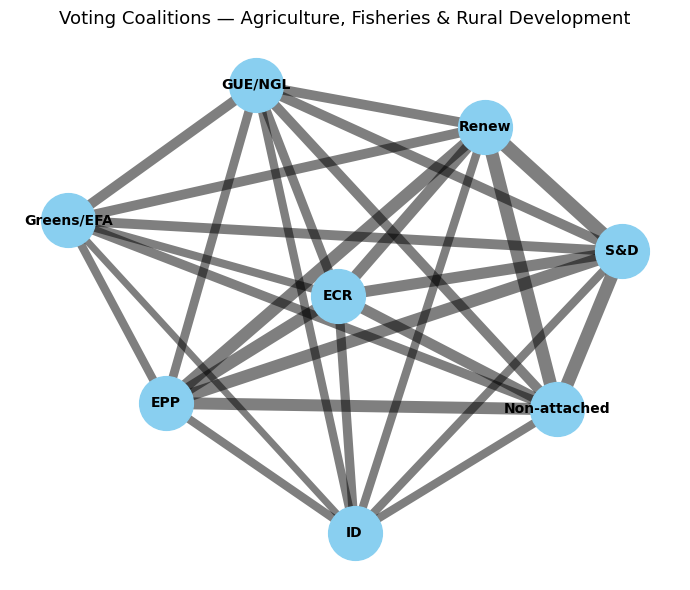

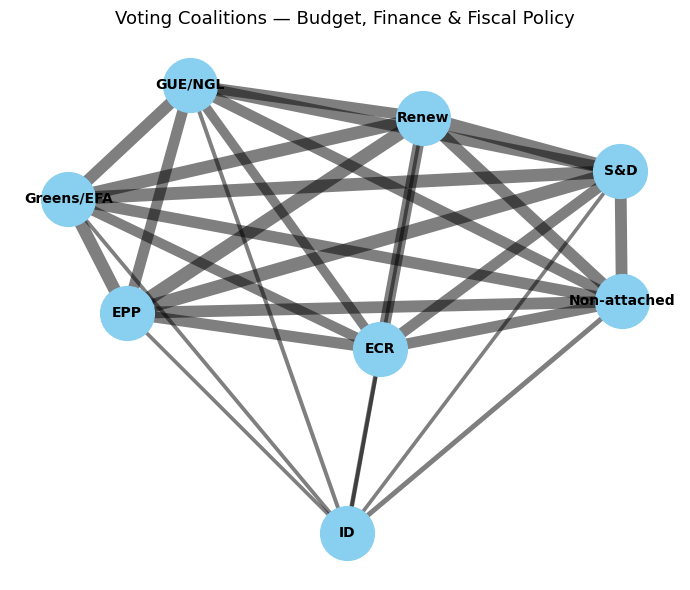

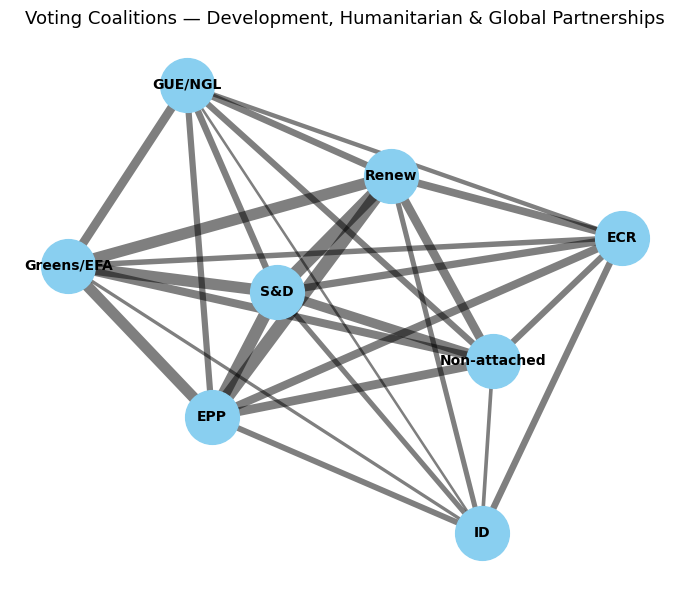

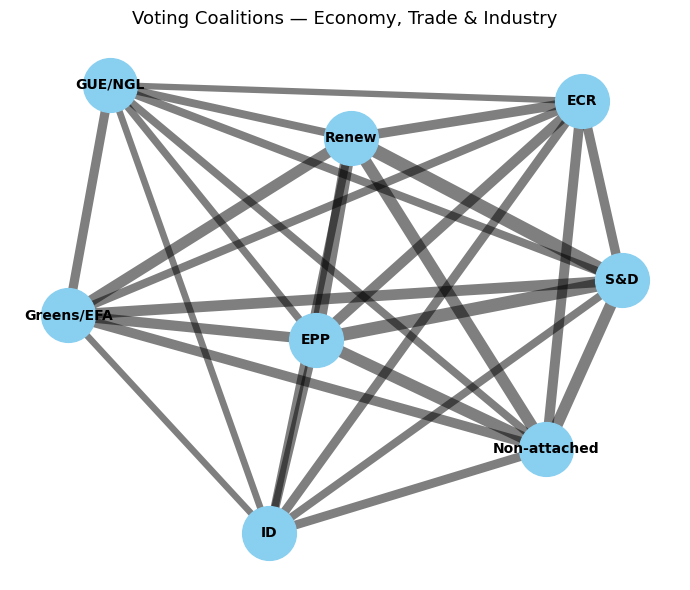

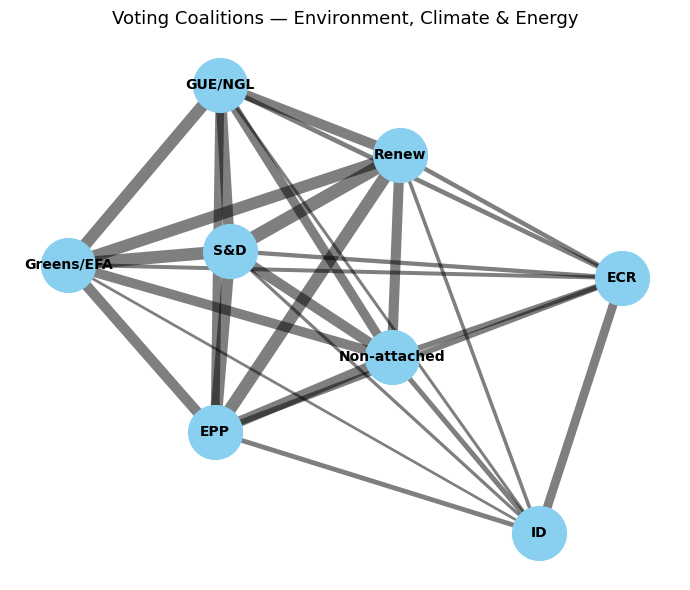

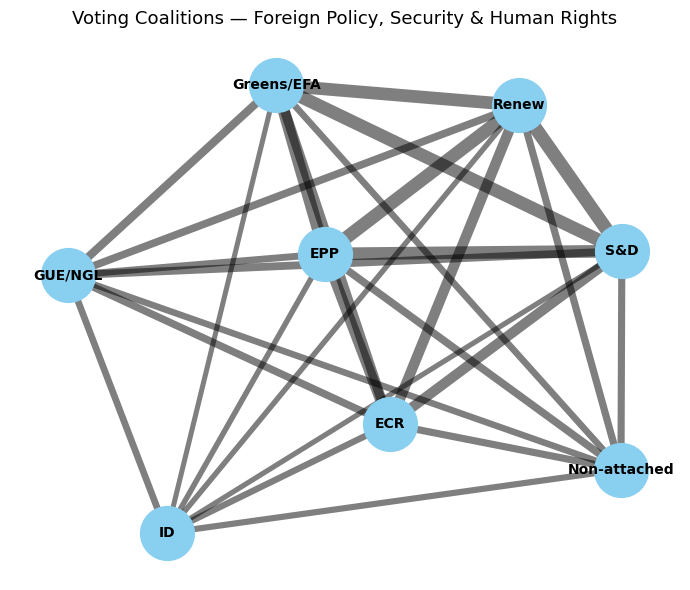

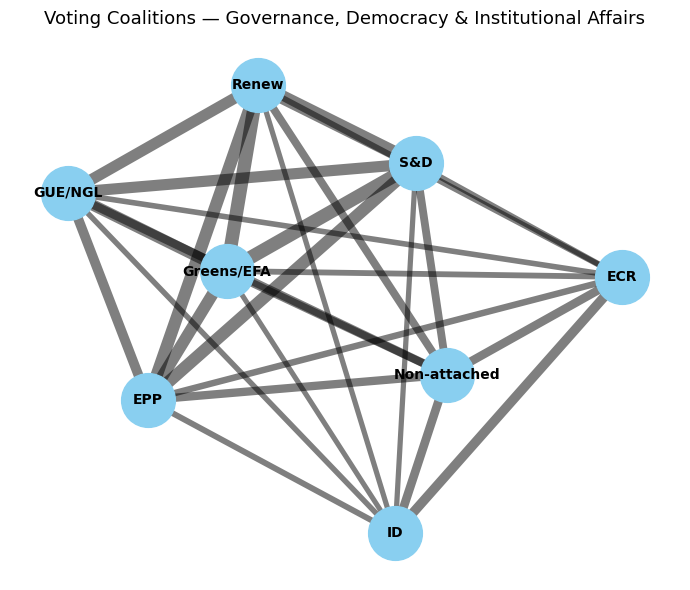

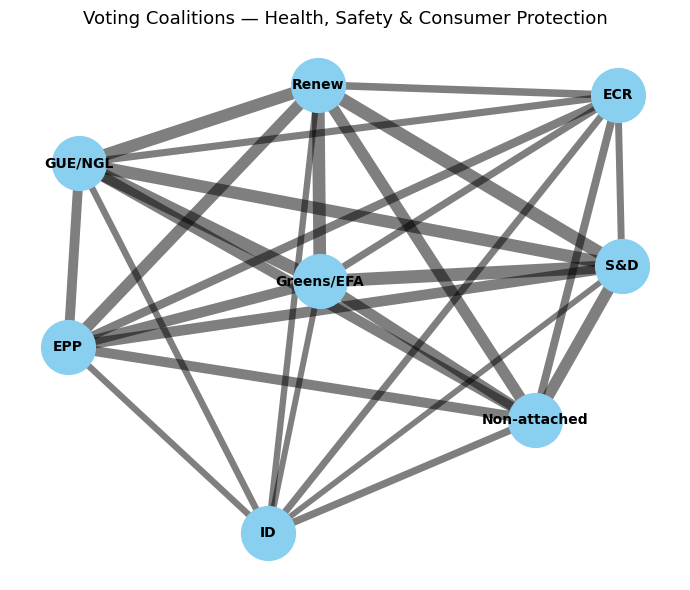

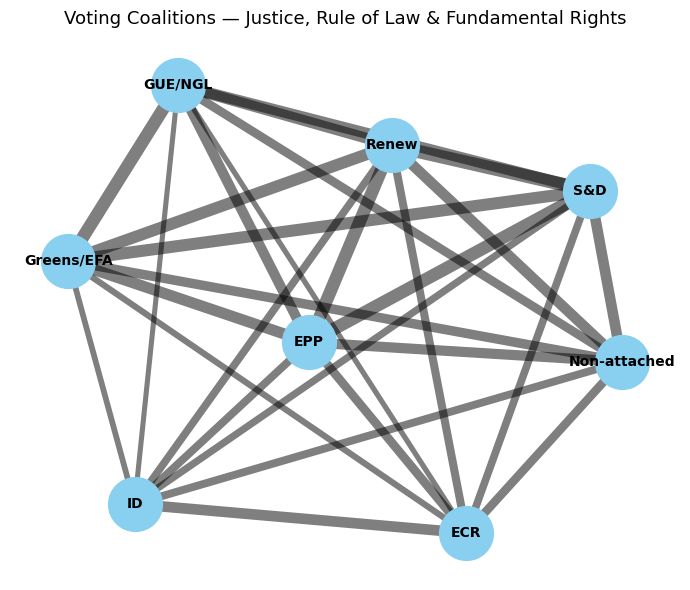

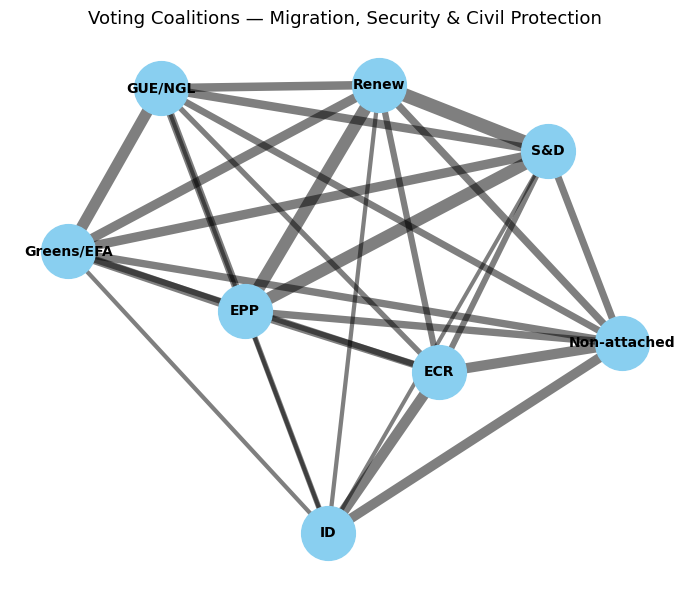

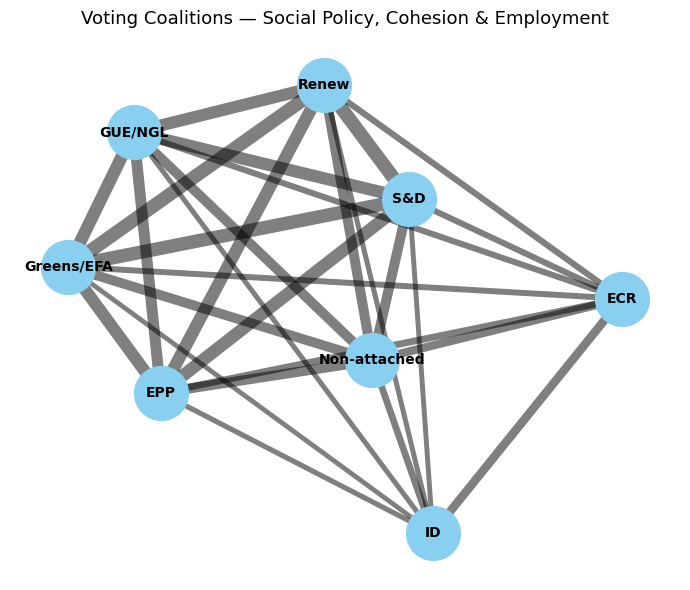

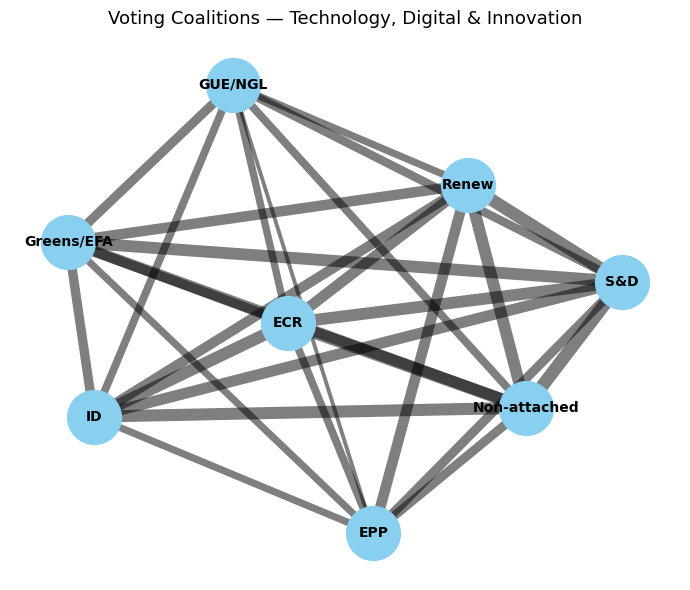

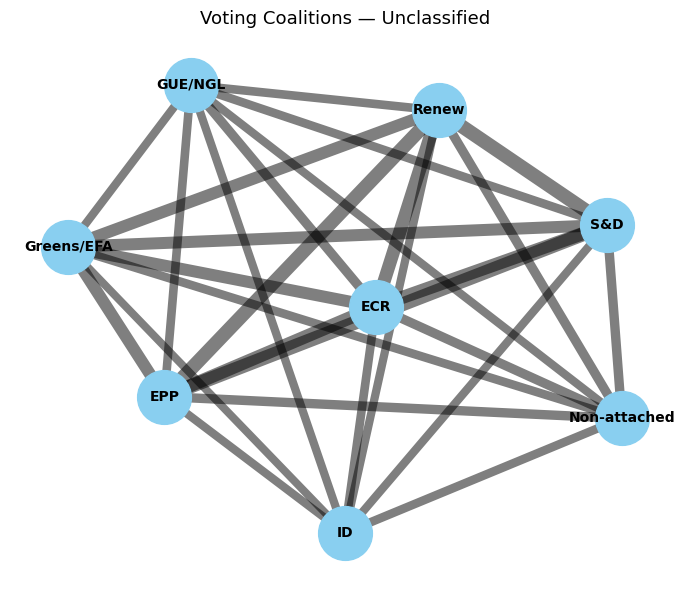

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Ensure vote_number is string for consistent merges
df_macrotopics["vote_number"] = df_macrotopics["vote_number"].astype(str)

# Identify vote columns
vote_cols = [c for c in df_votes.columns if c.isdigit()]

# Melt the votes table (wide → long)
df_long = df_votes.melt(
    id_vars=["member.id", "member.group.short_label"],
    value_vars=vote_cols,
    var_name="vote_number",
    value_name="vote_choice"
)

# Clean and merge with macrotopics
df_long["vote_number"] = df_long["vote_number"].astype(str)
df_long["vote_choice"] = df_long["vote_choice"].str.strip().fillna("DID_NOT_VOTE")
df_merged = df_long.merge(df_macrotopics, on="vote_number", how="left")

# ✅ NEW STEP — keep only the first macrotopic if multiple exist
df_merged["macrotopic"] = (
    df_merged["macrotopic"]
    .astype(str)
    .apply(lambda x: x.split(";")[0].strip() if ";" in x else x.strip())
)

# --- Compute co-voting similarity ---
def compute_similarity(df_topic):
    groups = df_topic["member.group.short_label"].unique()
    similarity = pd.DataFrame(0.0, index=groups, columns=groups)

    for vid, sub in df_topic.groupby("vote_number"):
        choices = (
            sub.groupby("member.group.short_label")["vote_choice"]
            .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)
        )
        for g1 in groups:
            for g2 in groups:
                if g1 == g2:
                    continue
                if g1 in choices.index and g2 in choices.index:
                    if choices[g1] == choices[g2]:
                        similarity.loc[g1, g2] += 1

    n_votes = df_topic["vote_number"].nunique()
    if n_votes > 0:
        similarity = similarity / n_votes
    return similarity

# --- Plot coalition graph ---
def plot_macrotopic_graph(df_topic, topic_name):
    sim = compute_similarity(df_topic)
    G = nx.Graph()

    for g1 in sim.index:
        G.add_node(g1)
    for g1 in sim.index:
        for g2 in sim.columns:
            w = sim.loc[g1, g2]
            if g1 < g2 and w > 0:
                G.add_edge(g1, g2, weight=w)

    plt.figure(figsize=(7, 6))
    pos = nx.spring_layout(G, seed=42, k=0.6)
    weights = [G[u][v]["weight"] * 10 for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="#89CFF0")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5)

    plt.title(f"Voting Coalitions — {topic_name}", fontsize=13, pad=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- Generate one graph per macrotopic ---
for topic_name, df_topic in df_merged.groupby("macrotopic"):
    if df_topic["vote_number"].nunique() < 3:
        continue  # skip small topics
    plot_macrotopic_graph(df_topic, topic_name)

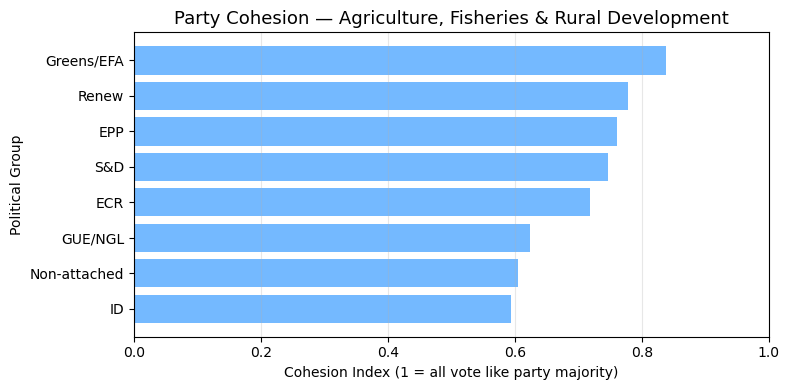

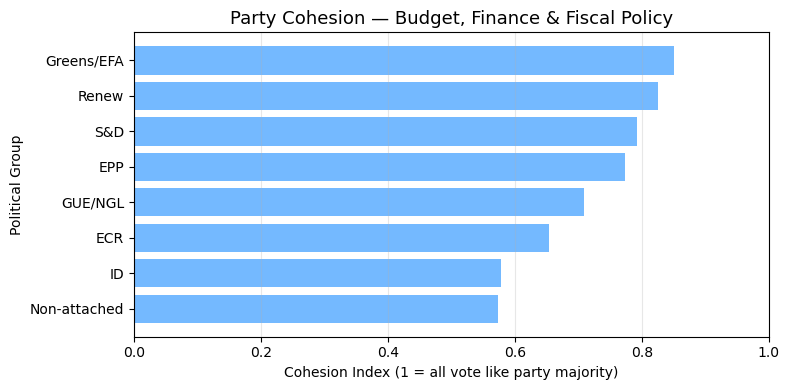

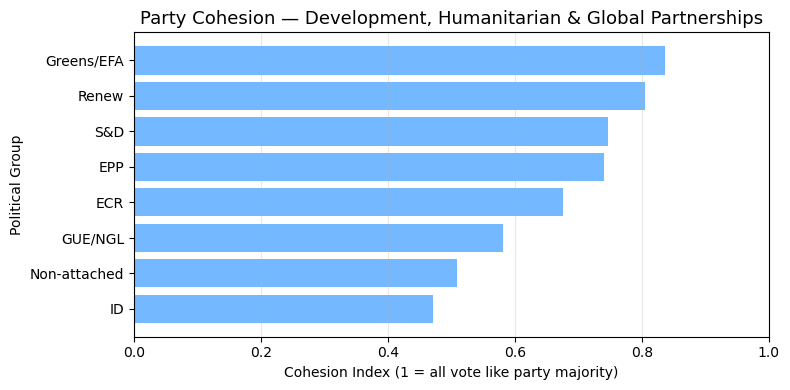

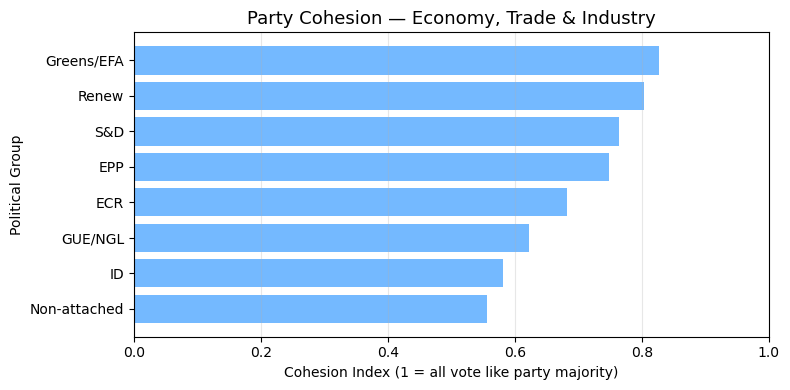

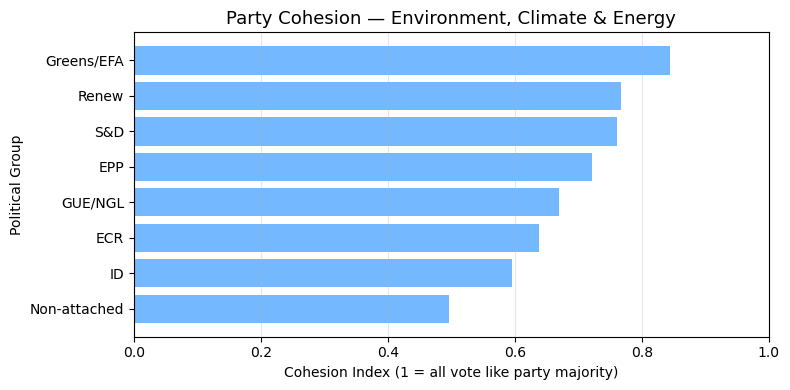

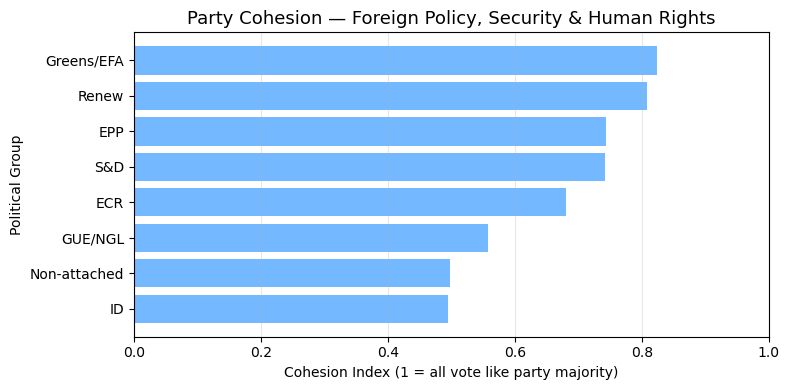

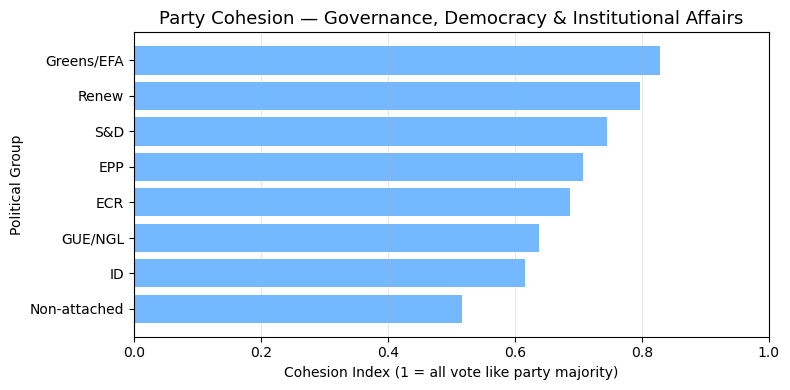

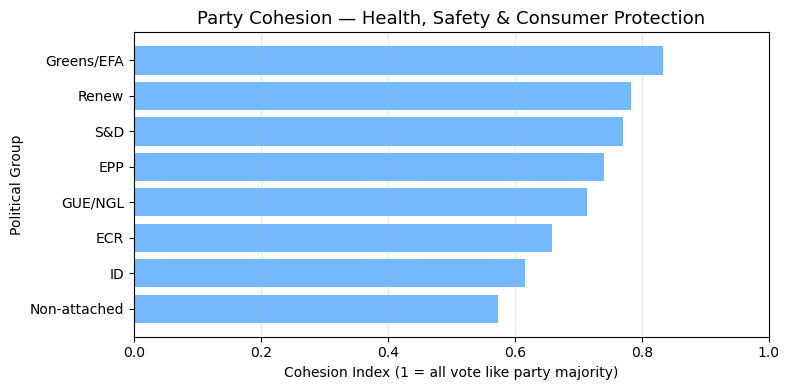

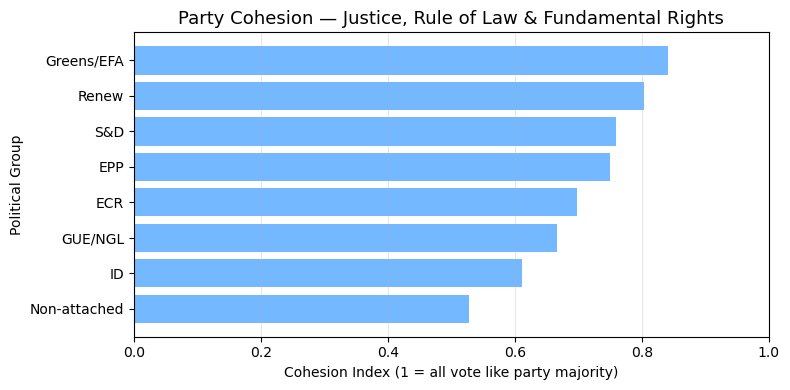

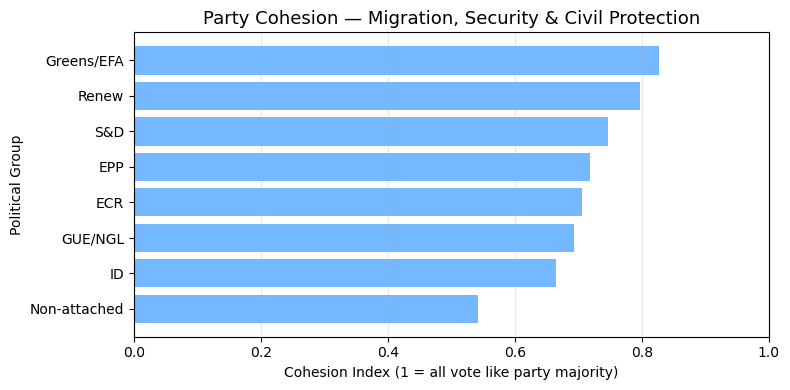

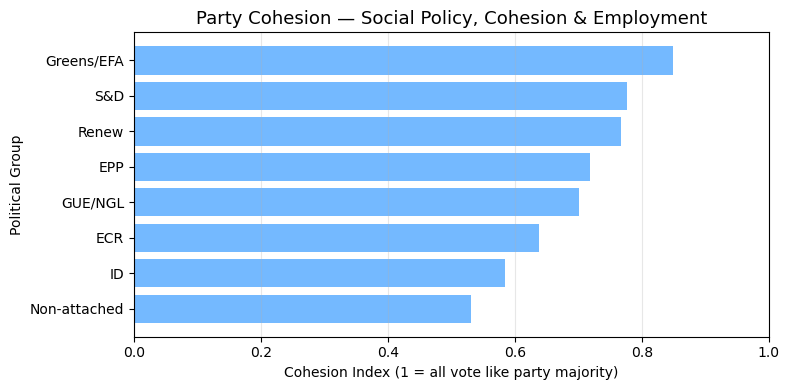

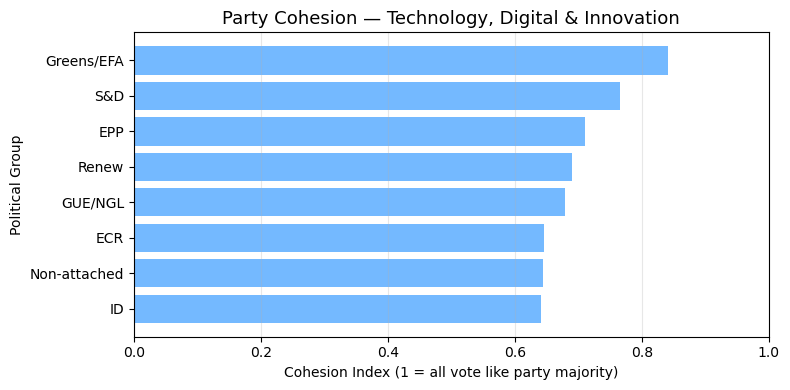

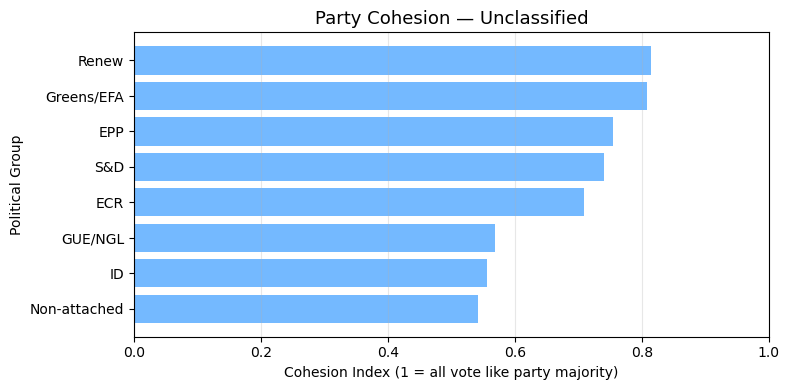

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- PREPROCESS (same as before) ---
df_macrotopics["vote_number"] = df_macrotopics["vote_number"].astype(str)
vote_cols = [c for c in df_votes.columns if c.isdigit()]

df_long = df_votes.melt(
    id_vars=["member.id", "member.group.short_label"],
    value_vars=vote_cols,
    var_name="vote_number",
    value_name="vote_choice"
)

df_long["vote_number"] = df_long["vote_number"].astype(str)
df_long["vote_choice"] = df_long["vote_choice"].str.strip().fillna("DID_NOT_VOTE")

df_merged = df_long.merge(df_macrotopics, on="vote_number", how="left")

# Keep only the first macrotopic if several
df_merged["macrotopic"] = (
    df_merged["macrotopic"]
    .astype(str)
    .apply(lambda x: x.split(";")[0].strip() if ";" in x else x.strip())
)

# --- 1️⃣ Compute intra-party cohesion index per macrotopic ---
def compute_party_cohesion(df_topic):
    """
    For each political group, compute share of members who vote
    with the majority of their group across all votes in this topic.
    """
    cohesion_data = []
    for group, sub in df_topic.groupby("member.group.short_label"):
        votes = sub["vote_number"].unique()
        agree_rates = []
        for vid in votes:
            vsub = sub[sub["vote_number"] == vid]
            if vsub.empty:
                continue
            majority_vote = (
                vsub["vote_choice"].mode()[0]
                if not vsub["vote_choice"].mode().empty
                else None
            )
            if majority_vote is None:
                continue
            agree = (vsub["vote_choice"] == majority_vote).mean()
            agree_rates.append(agree)
        if agree_rates:
            cohesion = np.mean(agree_rates)
            cohesion_data.append({"group": group, "cohesion": cohesion})
    return pd.DataFrame(cohesion_data)

# --- 2️⃣ Plot cohesion bar chart for each macrotopic ---
for topic_name, df_topic in df_merged.groupby("macrotopic"):
    if df_topic["vote_number"].nunique() < 3:
        continue  # skip small topics

    cohesion_df = compute_party_cohesion(df_topic)
    if cohesion_df.empty:
        continue

    cohesion_df = cohesion_df.sort_values("cohesion", ascending=False)

    plt.figure(figsize=(8, 4))
    plt.barh(cohesion_df["group"], cohesion_df["cohesion"], color="#74B9FF")
    plt.xlim(0, 1)
    plt.xlabel("Cohesion Index (1 = all vote like party majority)")
    plt.ylabel("Political Group")
    plt.title(f"Party Cohesion — {topic_name}", fontsize=13)
    plt.grid(axis="x", alpha=0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

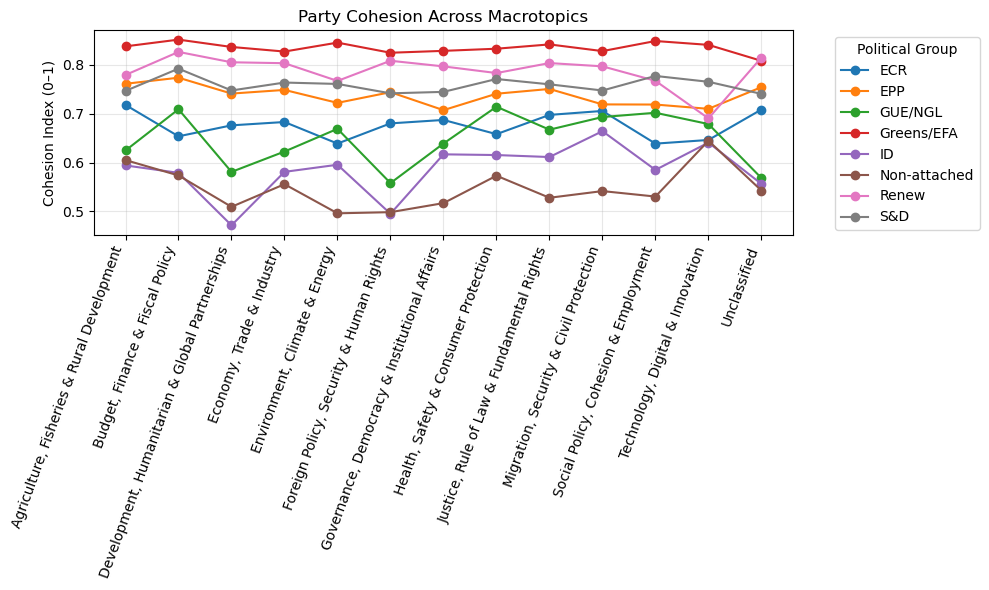

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Function from before ---
def compute_party_cohesion(df_topic):
    cohesion_data = []
    for group, sub in df_topic.groupby("member.group.short_label"):
        votes = sub["vote_number"].unique()
        agree_rates = []
        for vid in votes:
            vsub = sub[sub["vote_number"] == vid]
            if vsub.empty:
                continue
            majority_vote = (
                vsub["vote_choice"].mode()[0]
                if not vsub["vote_choice"].mode().empty
                else None
            )
            if majority_vote is None:
                continue
            agree = (vsub["vote_choice"] == majority_vote).mean()
            agree_rates.append(agree)
        if agree_rates:
            cohesion = np.mean(agree_rates)
            cohesion_data.append({"group": group, "cohesion": cohesion})
    return pd.DataFrame(cohesion_data)

# --- Compute cohesion per macrotopic ---
all_cohesions = []
for topic_name, df_topic in df_merged.groupby("macrotopic"):
    if df_topic["vote_number"].nunique() < 3:
        continue
    cohesion_df = compute_party_cohesion(df_topic)
    cohesion_df["macrotopic"] = topic_name
    all_cohesions.append(cohesion_df)

df_cohesion_all = pd.concat(all_cohesions, ignore_index=True)

# --- Reshape to wide format for easy plotting ---
df_wide = df_cohesion_all.pivot(index="macrotopic", columns="group", values="cohesion")

# --- Plot cohesion across macrotopics per party ---
plt.figure(figsize=(10, 6))
for group in df_wide.columns:
    plt.plot(df_wide.index, df_wide[group], marker="o", label=group)

plt.xticks(rotation=70, ha="right")
plt.ylabel("Cohesion Index (0–1)")
plt.title("Party Cohesion Across Macrotopics")
plt.legend(title="Political Group", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

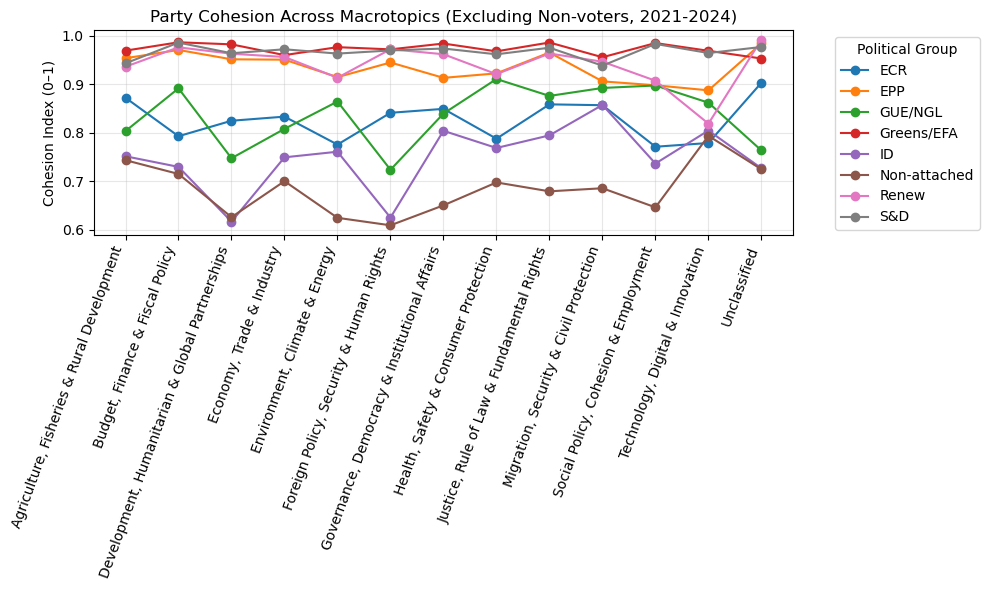

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Modified Function (ignores "DID_NOT_VOTE" / "DID NOT VOTE") ---
def compute_party_cohesion(df_topic):
    cohesion_data = []
    for group, sub in df_topic.groupby("member.group.short_label"):
        # Exclude DID_NOT_VOTE or variants
        sub = sub[~sub["vote_choice"].isin(["DID_NOT_VOTE"])]
        votes = sub["vote_number"].unique()
        agree_rates = []

        for vid in votes:
            vsub = sub[sub["vote_number"] == vid]
            if vsub.empty:
                continue
            majority_vote = (
                vsub["vote_choice"].mode()[0]
                if not vsub["vote_choice"].mode().empty
                else None
            )
            if majority_vote is None:
                continue
            agree = (vsub["vote_choice"] == majority_vote).mean()
            agree_rates.append(agree)

        if agree_rates:
            cohesion = np.mean(agree_rates)
            cohesion_data.append({"group": group, "cohesion": cohesion})
    return pd.DataFrame(cohesion_data)

# --- Compute cohesion per macrotopic ---
all_cohesions = []
for topic_name, df_topic in df_merged.groupby("macrotopic"):
    if df_topic["vote_number"].nunique() < 3:
        continue
    cohesion_df = compute_party_cohesion(df_topic)
    cohesion_df["macrotopic"] = topic_name
    all_cohesions.append(cohesion_df)

df_cohesion_all = pd.concat(all_cohesions, ignore_index=True)

# --- Reshape to wide format ---
df_wide = df_cohesion_all.pivot(index="macrotopic", columns="group", values="cohesion")

# --- Plot ---
plt.figure(figsize=(10, 6))
for group in df_wide.columns:
    plt.plot(df_wide.index, df_wide[group], marker="o", label=group)

plt.xticks(rotation=70, ha="right")
plt.ylabel("Cohesion Index (0–1)")
plt.title("Party Cohesion Across Macrotopics (Excluding Non-voters, 2021-2024)")
plt.legend(title="Political Group", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()